In [17]:
# Install all dask components
# https://docs.dask.org/en/latest/install.html
# ! pipenv install "dask[complete]"

# Credit to AlexK

In [28]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import json

from operator import add

import pandas as pd
import numpy as np
import h5py

from prep import accounts_csvs

In [15]:
# Dask Imports 
import numpy as np
import pandas as pd

import dask.bag as db
import dask.array as da
import dask.dataframe as dd

from dask import delayed
from dask.distributed import Client
from dask.multiprocessing import get

`Graph Theory` the study of graphs, which are mathematical structures used to model pairwise relationships between objects.  In this context graphs are made of `vertices` (nodes or points) that are connected by `edges` (arcs, lines).  Graphs can be `undirected` (no distinction between two vertices associated with each edge) or `directed` from one vertex to another.

`Directed Acyclic Graph (DAG)` a finite directed graph with no directed cycles.  It consists of finitely many vertices and edges, with each edge directed from one vertyex to another, such that there is no way to start at any vertex `v` and follow a consistently directed sequence of edges that eventually loops back to `v` again.  IE. Spreadsheet; `vertex` = cell and `edge` is whenever a formula in one cell uses the value of another

### Dask Delayed

In [151]:
from dask import delayed

@delayed
def inc(x):
    return x + 1

@delayed
def add(x, y):
    return x + y

@delayed
def multiply(x, y):
    return x * y

Here we have used the delayed annotation to show that we want these functions to operate lazily - to save the set of inputs and execute only on demand. dask.delayed is also a function which can do this, without the annotation, leaving the original function unchanged, e.g.,  

`delayed_inc = delayed(inc)`

In [152]:
# this looks like ordinary code
x = inc(15)
y = inc(30)
total = add(x, y)
product = multiply(x, y)
# incx, incy and total are all delayed objects. 
# They contain a prescription of how to execute

In [153]:
total

Delayed('add-8cc06228-4cd8-41c5-a78a-a347a632849b')

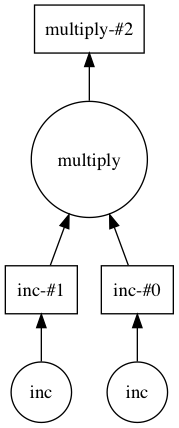

In [154]:
product.visualize()

In [155]:
total.compute()

47

In [156]:
product.compute()

496

In [157]:
import pandas as pd
import os
filenames = [os.path.join('data', 'accounts.%d.csv' % i) for i in [0, 1, 2]]
filenames

['data/accounts.0.csv', 'data/accounts.1.csv', 'data/accounts.2.csv']

In [158]:
%%time

# normal, sequential code
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na, nb, nc])
print(total)

3000000
CPU times: user 858 ms, sys: 145 ms, total: 1 s
Wall time: 1.02 s


In [159]:
from dask.multiprocessing import get

# verbose version
delayed_read_csv = delayed(pd.read_csv)
a = delayed_read_csv(filenames[0])
b = delayed_read_csv(filenames[1])
c = delayed_read_csv(filenames[2])

delayed_len = delayed(len)
na = delayed_len(a)
nb = delayed_len(b)
nc = delayed_len(c)

delayed_sum = delayed(sum)

total = delayed_sum([na, nb, nc])
%time print(total.compute(get=get))

# concise version
csvs = [delayed(pd.read_csv)(fn) for fn in filenames]
lens = [delayed(len)(csv) for csv in csvs]
%time total = delayed(sum)(lens)

3000000
CPU times: user 17 ms, sys: 35.5 ms, total: 52.5 ms
Wall time: 416 ms
CPU times: user 182 µs, sys: 92 µs, total: 274 µs
Wall time: 256 µs


In [160]:
def add(x, y):
    return x + y

def multiply(x, y):
    return x * y
# Sometimes we defer computations with strings
x = 15
y = 30
z = "add(x, y)"
m = "multiply(x, y)"
eval(z), eval(m)

(45, 450)

In [161]:
dict(total.dask)

{'len-a1b0e28d-04af-4765-85b3-8cc9e8a1f5d7': (<function len>,
  'read_csv-e901f272-a9f7-4919-8250-6d33686df813'),
 'len-b4fc0c24-57e4-4d50-a32a-632dedc9680b': (<function len>,
  'read_csv-4a4c824f-e689-4199-9f27-6d43e3ed5da6'),
 'len-ba39623a-9af4-4143-ae15-e0022f213f2b': (<function len>,
  'read_csv-81a9fbc7-3c9f-4b78-808f-9fbf175c7286'),
 'read_csv-4a4c824f-e689-4199-9f27-6d43e3ed5da6': (<function pandas.io.parsers._make_parser_function.<locals>.parser_f>,
  'data/accounts.1.csv'),
 'read_csv-81a9fbc7-3c9f-4b78-808f-9fbf175c7286': (<function pandas.io.parsers._make_parser_function.<locals>.parser_f>,
  'data/accounts.0.csv'),
 'read_csv-e901f272-a9f7-4919-8250-6d33686df813': (<function pandas.io.parsers._make_parser_function.<locals>.parser_f>,
  'data/accounts.2.csv'),
 'sum-8799f48b-a96b-4750-8819-d221eb2911c2': (<function sum>,
  ['len-ba39623a-9af4-4143-ae15-e0022f213f2b',
   'len-b4fc0c24-57e4-4d50-a32a-632dedc9680b',
   'len-a1b0e28d-04af-4765-85b3-8cc9e8a1f5d7'])}

### Dask Bagging

Parallel lists for semi-structured data (messy).  `dask.bag` is equivalent to map, filter, toolz + parallel execution

In [162]:
import dask.bag as db
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
b

dask.bag<from_se..., npartitions=10>

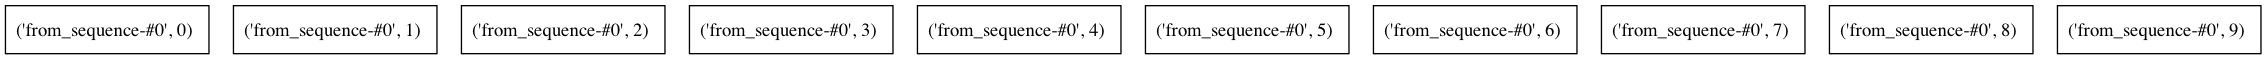

In [163]:
b.visualize()

In [164]:
import os
b = db.read_text(os.path.join('data', 'accounts.*.json.gz'))
b

dask.bag<bag-fro..., npartitions=50>

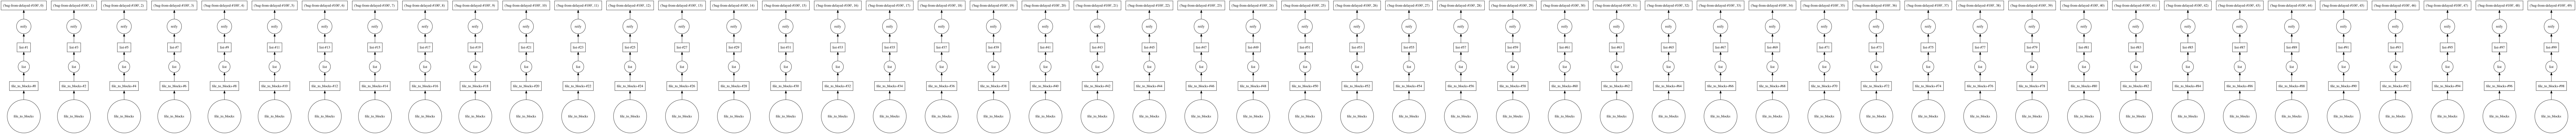

In [16]:
b.visualize()

Bag objects hold the standard functional API found in projects like the Python standard library, toolz, or pyspark, including map, filter, groupby, etc..

As with Array and DataFrame objects, operations on Bag objects create new bags. Call the .compute() method to trigger execution.

Dask.bag uses dask.multiprocessing.get by default. For examples using dask.bag with a distributed cluster see

In [ ]:
# specify own path
my_path = "/Users/amelie/data/"
path_to_gutenberg = f'{my_path}gutenberg/aleph.gutenberg.org/0/1/1.txt.gz'

In [165]:
b = db.read_text(path_to_gutenberg, compression='gzip', errors='replace').str.strip().str.rstrip(",.!:;'-\"").str.lstrip("'\"").str.lower().str.split(' ')

In [166]:
list(b.flatten()) # concatenate nested lists into one long list

['',
 '',
 '===========================================================',
 '',
 'note:',
 '',
 'this',
 'file',
 'combines',
 'the',
 'first',
 'two',
 'project',
 'gutenberg',
 'files,',
 'both',
 'of',
 'which',
 'were',
 'given',
 'the',
 'filenumber',
 '#1.',
 'there',
 'are',
 'several',
 'duplicate',
 'files',
 'here.',
 'there',
 'were',
 'many',
 'updates',
 'over',
 'the',
 'years.',
 '',
 'all',
 'of',
 'the',
 'original',
 'files',
 'are',
 'included',
 'in',
 'the',
 'old"',
 'subdirectory',
 'which',
 'may',
 'be',
 'accessed',
 'under',
 'the',
 '"more',
 'files"',
 'listing',
 'in',
 'the',
 'pg',
 'catalog',
 'of',
 'this',
 'file.',
 'no',
 'changes',
 'have',
 'been',
 'made',
 'in',
 'these',
 'original',
 'etexts',
 '',
 '===========================================================',
 '',
 '',
 '**welcome',
 'to',
 'the',
 'world',
 'of',
 'free',
 'plain',
 'vanilla',
 'electronic',
 'texts**',
 '',
 '**etexts',
 'readable',
 'by',
 'both',
 'humans',
 'and',
 'by',

In [168]:
b = db.from_sequence(range(5))
b.compute()

[0, 1, 2, 3, 4]

In [169]:
b = b.filter(lambda x: x % 2 == 0)
b.compute()

[0, 2, 4]

In [170]:
from operator import add
b = db.from_sequence([1, 2, 3, 4, 5], npartitions=2)

In [171]:
b.accumulate(add).compute()

[1, 3, 6, 10, 15]

In [172]:
b.accumulate(add, initial=-1).compute()

[-1, 0, 2, 5, 9, 14]

In [24]:
b.count().compute() # count is len, count number of elements in a collection

5

In [173]:
b = db.from_sequence([1, 2, 3, 4, 5, 3, 4, 5, 6, 1, 2, 3, 4])
sorted(b.distinct()) # distinct elements of a collection, unordered, without repeats

[1, 2, 3, 4, 5, 6]

In [174]:
def iseven(x):
    return x % 2 == 0
def isodd(x):
    return x % 2 != 0
def multiply(x, y):
    return x * y

In [27]:
b = db.from_sequence(range(10))
list(b.filter(iseven)) # filter elements in a collection by a predicate function

[0, 2, 4, 6, 8]

In [175]:
b = db.from_sequence(range(10))
list(b.filter(isodd)) # filter elements in a collection by a predicate function

[1, 3, 5, 7, 9]

In [176]:
b = db.from_sequence(range(10))
b.fold(add).compute()

45

In [177]:
b = db.from_sequence(range(1, 10))
b.fold(multiply).compute() # if only one function is given, then it is used for both functions binop and combine

362880

In [178]:
b = db.from_sequence(range(10))
iseven = lambda x: x % 2 == 0
add = lambda x, y: x + y
list(b.foldby(iseven, add)), dict(b.foldby(iseven, add))

([(True, 20), (False, 25)], {False: 25, True: 20})

In [179]:
sentence = "The quick brown fox jumped over the lazy dog!"
b = db.from_sequence(sentence.lower().split(' '))

In [180]:
b.compute()

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog!']

In [181]:
dict(b.frequencies()) # count number of occurences of each distinct element

{'brown': 1,
 'dog!': 1,
 'fox': 1,
 'jumped': 1,
 'lazy': 1,
 'over': 1,
 'quick': 1,
 'the': 2}

In [182]:
b = db.from_sequence(range(10))
iseven = lambda x: x % 2 == 0
dict(b.groupby(iseven))

{False: [7, 5, 9, 3, 1], True: [8, 6, 4, 2, 0]}

In [183]:
def is_even(n):
    return n % 2 == 0

a = db.from_sequence(range(51))
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
c = b.filter(is_even).map(lambda x: x ** 2)
c

dask.bag<map-lam..., npartitions=10>

In [37]:
# blocking form: wait for completion (which is very fast in this case)
c.compute()

[4, 16, 36, 64, 100]

In [184]:
b = db.from_sequence(range(5), npartitions=2)
b2 = db.from_sequence(range(5, 10), npartitions=2)

In [39]:
b.map(lambda x: x + 1).compute()

[1, 2, 3, 4, 5]

In [40]:
b.map(add, b2).compute()

[5, 7, 9, 11, 13]

In [185]:
b = db.from_sequence([{'name': 'Alice', 'credits': [1, 2, 3]},
                   {'name': 'Bob',   'credits': [10, 20]},
                   {'name': 'Alex',  'credits': [2, 3, 4, 10]}])

In [186]:
list(b.pluck('name'))

['Alice', 'Bob', 'Alex']

In [187]:
list(b.pluck('credits'))

[[1, 2, 3], [10, 20], [2, 3, 4, 10]]

In [188]:
b = db.from_sequence(range(10))
list(b.random_sample(0.25, random_state=42))

[1, 6, 7]

In [189]:
iseven = lambda x: x % 2 == 0
b = db.from_sequence(range(10))
list(b.remove(iseven))

[1, 3, 5, 7, 9]

In [191]:
b = db.from_sequence(['Alice Smith', 'Bob Jones', 'Charlie Smith', 'Alex Kunk', 'Albert Einstien', 'Joe Smith'])
list(b.str.lower())

['alice smith',
 'bob jones',
 'charlie smith',
 'alex kunk',
 'albert einstien',
 'joe smith']

In [192]:
list(b.str.match('*Smith'))

['Alice Smith', 'Charlie Smith', 'Joe Smith']

In [193]:
list(b.str.match('*A*'))

['Alice Smith', 'Alex Kunk', 'Albert Einstien']

In [194]:
b = db.from_sequence([10, 3, 5,7, 11, 4, 8])
list(b.topk(2))

[11, 10]

In [52]:
list(b.topk(2, key=lambda x: x % 2 == 0))

[10, 4]

In [195]:
b = db.from_sequence([(i, i + 1, i + 2) for i in range(10)])
b.compute()

[(0, 1, 2),
 (1, 2, 3),
 (2, 3, 4),
 (3, 4, 5),
 (4, 5, 6),
 (5, 6, 7),
 (6, 7, 8),
 (7, 8, 9),
 (8, 9, 10),
 (9, 10, 11)]

In [196]:
first, second, third = b.unzip(3)

In [197]:
first.compute()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [56]:
filename = os.path.join('data', 'accounts.*.json.gz')
lines = db.read_text(filename)
lines.take(1)

('{"id": 0, "name": "Hannah", "transactions": [{"transaction-id": 3126, "amount": 177}, {"transaction-id": 3190, "amount": 421}, {"transaction-id": 5493, "amount": 344}, {"transaction-id": 6178, "amount": 282}, {"transaction-id": 7465, "amount": 300}, {"transaction-id": 9241, "amount": 429}, {"transaction-id": 9254, "amount": 299}, {"transaction-id": 10109, "amount": 174}, {"transaction-id": 10197, "amount": 355}, {"transaction-id": 12484, "amount": 428}, {"transaction-id": 14544, "amount": 277}, {"transaction-id": 15494, "amount": 248}, {"transaction-id": 17259, "amount": 143}, {"transaction-id": 18193, "amount": 293}, {"transaction-id": 18526, "amount": 179}, {"transaction-id": 19385, "amount": 542}, {"transaction-id": 23387, "amount": 394}, {"transaction-id": 28016, "amount": 358}, {"transaction-id": 28273, "amount": 24}, {"transaction-id": 29684, "amount": 94}, {"transaction-id": 31485, "amount": 30}, {"transaction-id": 32663, "amount": 166}, {"transaction-id": 34585, "amount": 460

In [57]:
import json
js = lines.map(json.loads)
# take: inspect first few elements
js.take(1)

({'id': 0,
  'name': 'Hannah',
  'transactions': [{'amount': 177, 'transaction-id': 3126},
   {'amount': 421, 'transaction-id': 3190},
   {'amount': 344, 'transaction-id': 5493},
   {'amount': 282, 'transaction-id': 6178},
   {'amount': 300, 'transaction-id': 7465},
   {'amount': 429, 'transaction-id': 9241},
   {'amount': 299, 'transaction-id': 9254},
   {'amount': 174, 'transaction-id': 10109},
   {'amount': 355, 'transaction-id': 10197},
   {'amount': 428, 'transaction-id': 12484},
   {'amount': 277, 'transaction-id': 14544},
   {'amount': 248, 'transaction-id': 15494},
   {'amount': 143, 'transaction-id': 17259},
   {'amount': 293, 'transaction-id': 18193},
   {'amount': 179, 'transaction-id': 18526},
   {'amount': 542, 'transaction-id': 19385},
   {'amount': 394, 'transaction-id': 23387},
   {'amount': 358, 'transaction-id': 28016},
   {'amount': 24, 'transaction-id': 28273},
   {'amount': 94, 'transaction-id': 29684},
   {'amount': 30, 'transaction-id': 31485},
   {'amount': 166,

This can be utilized to query our data. Once we parse our JSON data into proper Python objects (dicts, lists, etc.) we can perform more interesting queries by creating small Python functions to run on our data.

In [58]:
# filter: keep only some elements of the sequence
js.filter(lambda record: record['name'] == 'Alice').take(1)

({'id': 1,
  'name': 'Alice',
  'transactions': [{'amount': 4683, 'transaction-id': 360},
   {'amount': 4621, 'transaction-id': 752},
   {'amount': 4527, 'transaction-id': 1678},
   {'amount': 4596, 'transaction-id': 2193},
   {'amount': 4733, 'transaction-id': 2283},
   {'amount': 5098, 'transaction-id': 3534},
   {'amount': 4404, 'transaction-id': 3556},
   {'amount': 4830, 'transaction-id': 3869},
   {'amount': 4736, 'transaction-id': 5206},
   {'amount': 4937, 'transaction-id': 5688},
   {'amount': 4495, 'transaction-id': 5964},
   {'amount': 4752, 'transaction-id': 7263},
   {'amount': 4853, 'transaction-id': 7409},
   {'amount': 4197, 'transaction-id': 7728},
   {'amount': 5166, 'transaction-id': 11099},
   {'amount': 4526, 'transaction-id': 12729},
   {'amount': 4697, 'transaction-id': 12789},
   {'amount': 4620, 'transaction-id': 13084},
   {'amount': 4881, 'transaction-id': 13167},
   {'amount': 4660, 'transaction-id': 15004},
   {'amount': 4867, 'transaction-id': 15028},
   {

In [59]:
def count_transactions(d):
    return {'name': d['name'], 'count': len(d['transactions'])}

# map: apply a function to each element
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .take(5))

({'count': 120, 'name': 'Alice'},
 {'count': 129, 'name': 'Alice'},
 {'count': 159, 'name': 'Alice'},
 {'count': 310, 'name': 'Alice'},
 {'count': 53, 'name': 'Alice'})

In [198]:
# pluck: select a field, as from a dictionary, element[field]
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .take(5))

(120, 129, 159, 310, 53)

In [61]:
# Average number of transactions for all of the Alice's
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .mean()
   .compute())

205.65391304347827

We can use flatten to de-nest

In [62]:
js.filter(lambda record: record['name'] == 'Alice').pluck('transactions').take(1)

([{'amount': 4683, 'transaction-id': 360},
  {'amount': 4621, 'transaction-id': 752},
  {'amount': 4527, 'transaction-id': 1678},
  {'amount': 4596, 'transaction-id': 2193},
  {'amount': 4733, 'transaction-id': 2283},
  {'amount': 5098, 'transaction-id': 3534},
  {'amount': 4404, 'transaction-id': 3556},
  {'amount': 4830, 'transaction-id': 3869},
  {'amount': 4736, 'transaction-id': 5206},
  {'amount': 4937, 'transaction-id': 5688},
  {'amount': 4495, 'transaction-id': 5964},
  {'amount': 4752, 'transaction-id': 7263},
  {'amount': 4853, 'transaction-id': 7409},
  {'amount': 4197, 'transaction-id': 7728},
  {'amount': 5166, 'transaction-id': 11099},
  {'amount': 4526, 'transaction-id': 12729},
  {'amount': 4697, 'transaction-id': 12789},
  {'amount': 4620, 'transaction-id': 13084},
  {'amount': 4881, 'transaction-id': 13167},
  {'amount': 4660, 'transaction-id': 15004},
  {'amount': 4867, 'transaction-id': 15028},
  {'amount': 4697, 'transaction-id': 15348},
  {'amount': 4450, 'transa

In [63]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .take(3))

({'amount': 4683, 'transaction-id': 360},
 {'amount': 4621, 'transaction-id': 752},
 {'amount': 4527, 'transaction-id': 1678})

In [64]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .mean()
   .compute())

1031.6643284200557

#### Groupby and Foldby
Often we want to group data by some function or key. We can do this either with the .groupby method, which is straightforward but forces a full shuffle of the data (expensive) or with the harder-to-use but faster .foldby method, which does a streaming combined groupby and reduction.  

`groupby`: Shuffles data so that all items with the same key are in the same key-value pair  
`foldby`: Walks through the data accumulating a result per key  
Note: the full groupby is particularly bad. In actual workloads you would do well to use foldby or switch to DataFrames if possible.

`groupby`
Groupby collects items in your collection so that all items with the same value under some function are collected together into a key-value pair.

In [199]:
b = db.from_sequence(['Alice', 'Bob', 'Charlie', 'Dan', 'Edith', 'Frank'])
b.groupby(len).compute()  # names grouped by length

[(7, ['Charlie']), (3, ['Dan', 'Bob']), (5, ['Edith', 'Frank', 'Alice'])]

In [200]:
b = db.from_sequence(list(range(10)))
b.groupby(lambda x: x % 2).compute()

[(0, [8, 2, 6, 4, 0]), (1, [7, 9, 5, 3, 1])]

In [67]:
b.groupby(lambda x: x % 2).starmap(lambda k, v: (k, max(v))).compute()

[(0, 8), (1, 9)]

#### foldby
Foldby can be quite odd at first. It is similar to the following functions from other libraries:

    toolz.reduceby
    pyspark.RDD.combineByKey
When using foldby you provide

    A key function on which to group elements
    A binary operator such as you would pass to reduce that you use to perform reduction per each group
    A combine binary operator that can combine the results of two reduce calls on different parts of your dataset.
Your reduction must be associative. It will happen in parallel in each of the partitions of your dataset. Then all of these intermediate results will be combined by the combine binary operator.

In [68]:
is_even = lambda x: x % 2
b.foldby(is_even, binop=max, combine=max).compute()

[(0, 8), (1, 9)]

In [69]:
from operator import add
def incr(tot, _):
    return tot+1

result = js.foldby(key='name', 
                   binop=incr, 
                   initial=0, 
                   combine=add, 
                   combine_initial=0).compute()
print(sorted(result))

[('Alice', 1150), ('Bob', 835), ('Charlie', 897), ('Dan', 1100), ('Edith', 900), ('Frank', 900), ('George', 950), ('Hannah', 1050), ('Ingrid', 1150), ('Jerry', 1000), ('Kevin', 850), ('Laura', 1250), ('Michael', 797), ('Norbert', 1150), ('Oliver', 850), ('Patricia', 850), ('Quinn', 770), ('Ray', 800), ('Sarah', 798), ('Tim', 1341), ('Ursula', 1097), ('Victor', 906), ('Wendy', 998), ('Xavier', 800), ('Yvonne', 850), ('Zelda', 850)]


Bags provide very general computation (any Python function.) This generality comes at cost. Bags have the following known limitations  

Bag operations tend to be slower than array/dataframe computations in the same way that Python tends to be slower than NumPy/Pandas  
`Bag.groupby` is slow. You should try to use `Bag.foldby` if possible. Using `Bag.foldby` requires more thought. Even better, consider creating a normalised dataframe.

### Distributed

Dask comes with four available schedulers:

`dask.threaded.get`: a scheduler backed by a thread pool  
`dask.multiprocessing.get`: a scheduler backed by a process pool  
`dask.async.get_sync`: a synchronous scheduler, good for debugging  
`distributed.Client.get`: a distributed scheduler for executing graphs on multiple machines.  

To select one of these for computation, you can specify at the time of asking for a result  

`myvalue.compute(get=dask.async.get_sync)`  # for debugging

In [7]:
# be sure to shut down other kernels running distributed clients
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:44005,Cluster Workers: 4 Cores: 8 Memory: 33.36 GB


In [43]:
from dask import delayed
import time

def inc(x):
    time.sleep(5)
    return x + 1

def dec(x):
    time.sleep(3)
    return x - 1

def add(x, y):
    time.sleep(7)
    return x + y

In [44]:
x = delayed(inc)(1)
y = delayed(dec)(2)
total = delayed(add)(x, y)
total.compute()

3

In reality this should be done on a cluster...

In [45]:
# be sure to shut down other kernels running distributed clients
from dask.distributed import Client
client = Client(processes=False)

### Dask Arrays

Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.

    Parallel: Uses all of the cores on your computer
    Larger-than-memory: Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
    Blocked Algorithms: Perform large computations by performing many smaller computations


Blocked Algorithms execute on a large dataset by breaking it up into many small blocks. (npartitions)

In [2]:
from dask import delayed

In [3]:
x = np.arange(3)
da.asarray(x).compute()

array([0, 1, 2])

In [4]:
value = delayed(np.ones)(5)
array = da.from_delayed(value, (5,), float)
array.compute()

array([1., 1., 1., 1., 1.])

In [5]:
x = np.array([5, 1, 3, 6])
d = da.from_array(x, chunks=2)
d.topk(2).compute()

array([6, 5])

In [6]:
data = [da.from_array(np.ones((4, 4)), chunks=(2, 2)) for i in range(3)]
data

[dask.array<array, shape=(4, 4), dtype=float64, chunksize=(2, 2)>,
 dask.array<array, shape=(4, 4), dtype=float64, chunksize=(2, 2)>,
 dask.array<array, shape=(4, 4), dtype=float64, chunksize=(2, 2)>]

In [7]:
x = da.concatenate(data, axis=0)
x.compute()

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [9]:
x = da.from_array(np.arange(10000), chunks=10)
h, bins = da.histogram(x, bins=10, range=[0, 10000])

In [10]:
bins

array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
        8000.,  9000., 10000.])

In [11]:
h.compute()

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

In [12]:
x = np.arange(10)
da.roll(x, 2).compute() # shifting

array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7])

In [13]:
da.sqrt([1,4,9]) 

array([1., 2., 3.])

In [81]:
da.square([1, 2, 3])

array([1, 4, 9])

In [82]:
a = da.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])  
a

[-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0]

In [83]:
da.trunc(a)

array([-1., -1., -0.,  0.,  1.,  1.,  2.])

In [84]:
x = da.ones((1000000, 1000000), chunks=(1000, 1000))
da.exp(x)[:1500, :1500].compute()

array([[2.71828183, 2.71828183, 2.71828183, ..., 2.71828183, 2.71828183,
        2.71828183],
       [2.71828183, 2.71828183, 2.71828183, ..., 2.71828183, 2.71828183,
        2.71828183],
       [2.71828183, 2.71828183, 2.71828183, ..., 2.71828183, 2.71828183,
        2.71828183],
       ...,
       [2.71828183, 2.71828183, 2.71828183, ..., 2.71828183, 2.71828183,
        2.71828183],
       [2.71828183, 2.71828183, 2.71828183, ..., 2.71828183, 2.71828183,
        2.71828183],
       [2.71828183, 2.71828183, 2.71828183, ..., 2.71828183, 2.71828183,
        2.71828183]])

In [85]:
# create data if it doesn't already exist
from prep import random_array
random_array()  

In [ ]:
# Load data with h5py
# this gives the load prescription, but does no real work.
import h5py
import os
f = h5py.File(os.path.join(os.getcwd(), 'data', 'random.hdf5'), mode='r')
dset = f['/x']

In [15]:
# Compute sum of large array, one million numbers at a time
sums = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]  # pull out numpy array
    sums.append(chunk.sum())

total = sum(sums)
print(total)

1000046195.5625


`dask.array` contains these algorithms
Dask.array is a NumPy-like library that does these kinds of tricks to operate on large datasets that don't fit into memory. It extends beyond the linear problems discussed above to full N-Dimensional algorithms and a decent subset of the NumPy interface.

Create `dask.array` object

You can create a dask.array Array object with the da.from_array function. This function accepts

    data: Any object that supports NumPy slicing, like dset
    chunks: A chunk size to tell us how to block up our array, like (1000000,)

In [16]:
import dask.array as da
x = da.from_array(dset, chunks=(1000000,))

Manipulate dask.array object as you would a numpy array

Now that we have an Array we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc..

The interface is familiar, but the actual work is different. `dask_array.sum()` does not do the same thing as `numpy_array.sum()`.

`dask_array.sum()` builds an expression of the computation. It does not do the computation yet. `numpy_array.sum()` computes the sum immediately.
  
Dask arrays are split into chunks. Each chunk must have computations run on that chunk explicitly. If the desired answer comes from a small slice of the entire dataset, running the computation over all data would be wasteful of CPU and memory.

In [18]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=()>

Dask.array objects are lazily evaluated. Operations like .sum build up a graph of blocked tasks to execute.

In [19]:
result.compute()

1000046200.0

In [20]:
# center around 10
x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [21]:
x.nbytes / 1e9  # Gigabytes of the input processed lazily

3.2

In [22]:
%%time
y.compute()     # Time to compute the result

CPU times: user 18.2 s, sys: 1.48 s, total: 19.7 s
Wall time: 3.04 s


array([ 9.99917852,  9.99998745, 10.00011108, 10.00003638, 10.00033581,
        9.99988332,  9.99904672,  9.99989051, 10.00023583, 10.00032111,
        9.99994599, 10.00031105,  9.99971088, 10.00102736,  9.99964975,
        9.99844584, 10.00033682,  9.99967819,  9.9999461 , 10.00013969,
       10.00105473,  9.99948251, 10.00005868,  9.99900151, 10.00032986,
       10.00002587,  9.99978991,  9.99989381, 10.0008393 , 10.00037399,
       10.00050884,  9.99913469, 10.00029206, 10.00015334,  9.99903322,
       10.00076596, 10.00022217, 10.00021327, 10.00036878,  9.99955881,
        9.99964234, 10.00020376,  9.99885954, 10.00122009,  9.9997014 ,
       10.00009436, 10.00059041,  9.99963047,  9.99971925,  9.99974218,
        9.999997  ,  9.99867721, 10.0004942 , 10.00083433,  9.99883702,
        9.99984486, 10.00022124,  9.99979286,  9.99946189, 10.00129181,
       10.00042318,  9.99963317,  9.9986171 ,  9.99930592,  9.99977292,
       10.00041845, 10.00076547,  9.99912763, 10.00027529,  9.99

In [94]:
import numpy as np

In [23]:
%%time
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

CPU times: user 12.2 s, sys: 920 ms, total: 13.1 s
Wall time: 13.1 s


In [24]:
%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 17.8 s, sys: 1.66 s, total: 19.5 s
Wall time: 3.18 s


Dask array computation ran in 4 seconds, but used 19 seconds of user CPU time. The numpy computation ran in 13.7 seconds and used 13.7 seconds of user CPU time.

#### Limitations
Dask.array does not implement the entire numpy interface. Users expecting this will be disappointed. Notably dask.array has the following failings:

    Dask does not implement all of np.linalg. This has been done by a number of excellent BLAS/LAPACK implementations and is the focus of numerous ongoing academic research projects.
    Dask.array does not support any operation where the resulting shape depends on the values of the array. In order to form the Dask graph we must be able to infer the shape of the array before actually executing the operation. This precludes operations like indexing one Dask array with another or operations like np.where.
    Dask.array does not attempt operations like sort which are notoriously difficult to do in parallel and are of somewhat diminished value on very large data (you rarely actually need a full sort). Often we include parallel-friendly alternatives like topk.
    Dask development is driven by immediate need, and so many lesser used functions, like np.full_like have not been implemented purely out of laziness. These would make excellent community contributions.

### Persist
Considering which data should be loaded by the workers, as opposed to passed, and which intermediate values to persist in worker memory, will in many cases determine the computation efficiency of a process.

In [25]:
import h5py
import os
f = h5py.File(os.path.join('data', 'random.hdf5'), mode='r')
dset = f['/x']
import dask.array as da
x = da.from_array(dset, chunks=(1000000,))

%time x.sum().compute()
%time x.sum().compute()

CPU times: user 1.18 s, sys: 1.13 s, total: 2.31 s
Wall time: 1.77 s
CPU times: user 1.2 s, sys: 1.09 s, total: 2.29 s
Wall time: 1.75 s


1000046200.0

In [26]:
# changes x from a set of delayed prescritions
# to a set of futures pointing to data in RAM
# See this on the UI dashboard.
x = x.persist()

In [27]:
%time x.sum().compute()
%time x.sum().compute()

CPU times: user 987 ms, sys: 55.8 ms, total: 1.04 s
Wall time: 296 ms
CPU times: user 788 ms, sys: 61.6 ms, total: 850 ms
Wall time: 312 ms


1000046200.0

### Dask DataFrames

The `dask.dataframe` module implements a blocked parallel DataFrame object that mimics a large subset of the Pandas DataFrame. One Dask DataFrame is comprised of many in-memory pandas DataFrames separated along the index. One operation on a Dask DataFrame triggers many pandas operations on the constituent pandas DataFrames in a way that is mindful of potential parallelism and memory constraints.

In [29]:
df = pd.DataFrame([[1, 2], [3, 4]], columns=list('AB')) 
ddf = dd.from_pandas(df, npartitions=2)
df2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('AB'))
ddf2 = dd.from_pandas(df2, npartitions=2)

In [30]:
ddf.compute()

,A,B
0,1,2
1,3,4


In [31]:
df.append(df2)

,A,B
0,1,2
1,3,4
0,5,6
1,7,8


In [112]:
df.append(df2, ignore_index=True)

,A,B
0,1,2
1,3,4
2,5,6
3,7,8


In [10]:
df = pd.DataFrame({'x': [1, 2, 3, 4, 5],
                    'y': [1., 2., 3., 4., 5.]})
ddf = dd.from_pandas(df, npartitions=2)

In [16]:
ddf

,x,y
npartitions=2,,
0,int64,float64
3,...,...
4,...,...


In [11]:
def myadd(row, a, b=1):
    return row.sum() + a + b

In [13]:
res = ddf.apply(myadd, axis=1, args=(2,), b=1.5)

In [14]:
res

Dask Series Structure:
npartitions=2
0    float64
3        ...
4        ...
dtype: float64
Dask Name: apply, 4 tasks

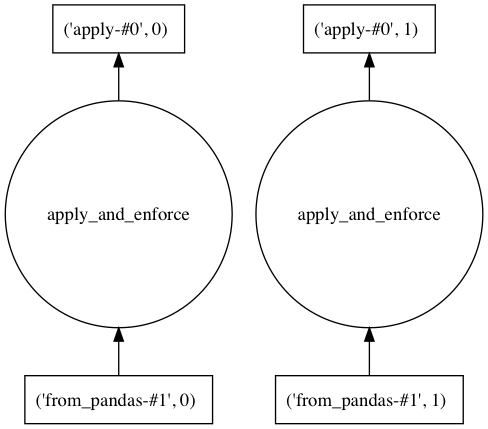

In [36]:
res.visualize()

In [117]:
res.compute()

0     5.5
1     7.5
2     9.5
3    11.5
4    13.5
dtype: float64

In [37]:
df = pd.DataFrame({'x': [1, 2, 4, 7, 11],
                   'y': [1., 2., 3., 4., 5.]})
ddf = dd.from_pandas(df, npartitions=2)

In [38]:
ddf.compute()

,x,y
0,1,1.0
1,2,2.0
2,4,3.0
3,7,4.0
4,11,5.0


`map_overlap(func, before, after, *args, **kwargs)` apply a function to each partition, sharing rows with adjacent partitions. this can be useful for implementing windowing functions such as `df.rolling(...).mean()` or `df.diff()`.

In [39]:
ddf.map_overlap(lambda df: df.rolling(2).sum(), 2, 0).compute()

,x,y
0,NaN,NaN
1,3.0,3.0
2,6.0,5.0
3,11.0,7.0
4,18.0,9.0


In [40]:
df = pd.DataFrame({'x': [1, 2, 3, 4, 5],
                   'y': [1., 2., 3., 4., 5.]})
ddf = dd.from_pandas(df, npartitions=2)

In [41]:
def myadd(df, a, b=1):
    return df.x + df.y + a + b
res = ddf.map_partitions(myadd, 1, b=2)

In [42]:
res.compute()

0     5.0
1     7.0
2     9.0
3    11.0
4    13.0
dtype: float64

In [43]:
res = ddf.map_partitions(lambda df: df.assign(z=df.x * df.y))

In [44]:
res.compute()

,x,y,z
0,1,1.0,1.0
1,2,2.0,4.0
2,3,3.0,9.0
3,4,4.0,16.0
4,5,5.0,25.0


In [45]:
a, b = res.random_split([0.5, 0.5]) 

In [46]:
a.compute()

,x,y,z
4,5,5.0,25.0


In [47]:
b.compute()

,x,y,z
0,1,1.0,1.0
1,2,2.0,4.0
2,3,3.0,9.0
3,4,4.0,16.0


In [48]:
df = pd.DataFrame({'x': range(50), 'y': range(50, 100)})
ddf = dd.from_pandas(df, npartitions=4)
ddf

,x,y
npartitions=4,,
0,int64,int64
13,...,...
26,...,...
39,...,...
49,...,...


In [49]:
#count the number of rows in a DataFrame. To do this, count the number of 
#rows in each partition, then sum the results:
res = ddf.reduction(lambda x: x.count(),
                    aggregate=lambda x: x.sum())
res.compute()

x    50
y    50
dtype: int64

In [50]:
def sum_and_count(x):
    return pd.DataFrame({'sum': x.sum(), 'count': x.count()})

res = ddf.reduction(sum_and_count,
                    aggregate=lambda x: x.groupby(level=0).sum())
res.compute()

,count,sum
x,50,1225
y,50,3725


In [51]:
df = pd.DataFrame({'A': [1, 1, 2, 2],  
                   'B': [1, 2, 3, 4],
                   'C': np.random.randn(4)})
ddf = dd.from_pandas(df, npartitions=3)

In [52]:
ddf.groupby('A').agg(['min', 'max']).compute()

B             C          
  min max       min       max
A                            
1   1   2 -1.117606  1.250662
2   3   4 -0.253652  1.214255

In [53]:
# different aggregations per column
ddf.groupby('A').agg({'B': ['min', 'max'], 'C': 'sum'}).compute()

B             C
  min max       sum
A                  
1   1   2  0.133056
2   3   4  0.960604

In [54]:
from prep import accounts_csvs
accounts_csvs(3, 1000000, 500)

import os
filename = os.path.join('data', 'accounts.*.csv')

In [55]:
import dask.dataframe as dd
df = dd.read_csv(filename)
# load and count number of rows
%time len(df)

CPU times: user 1.01 s, sys: 280 ms, total: 1.29 s
Wall time: 598 ms


3000000

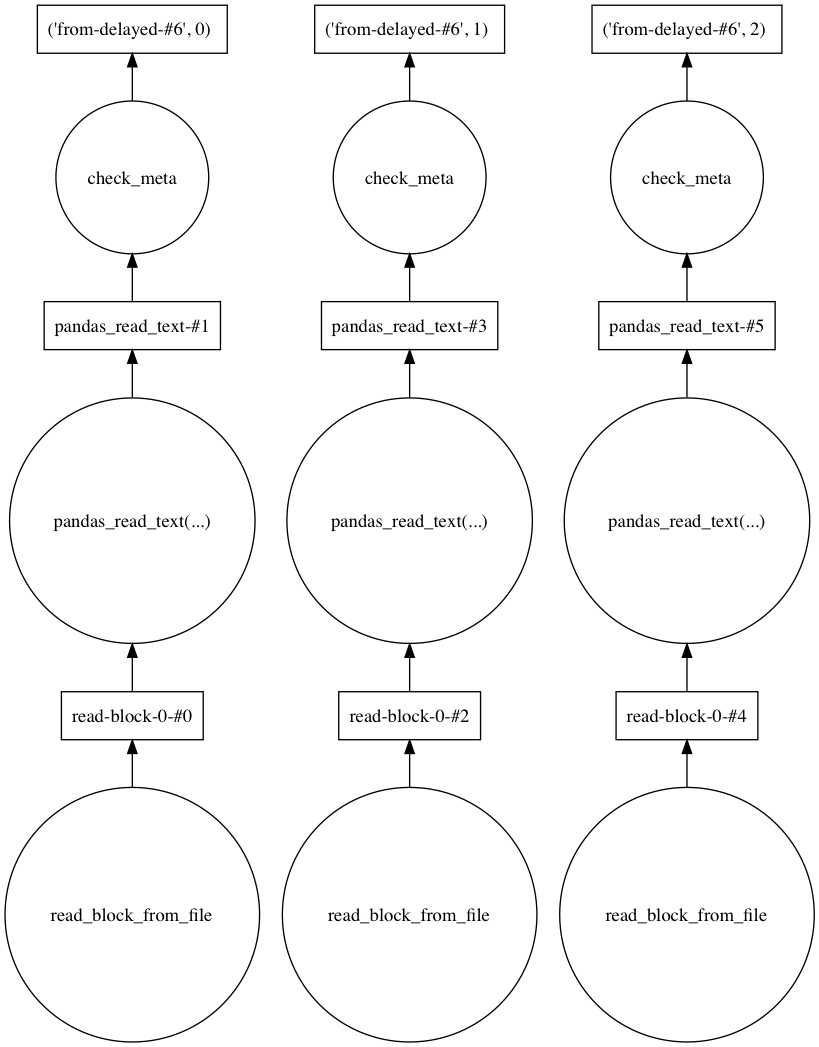

In [56]:
df.visualize()

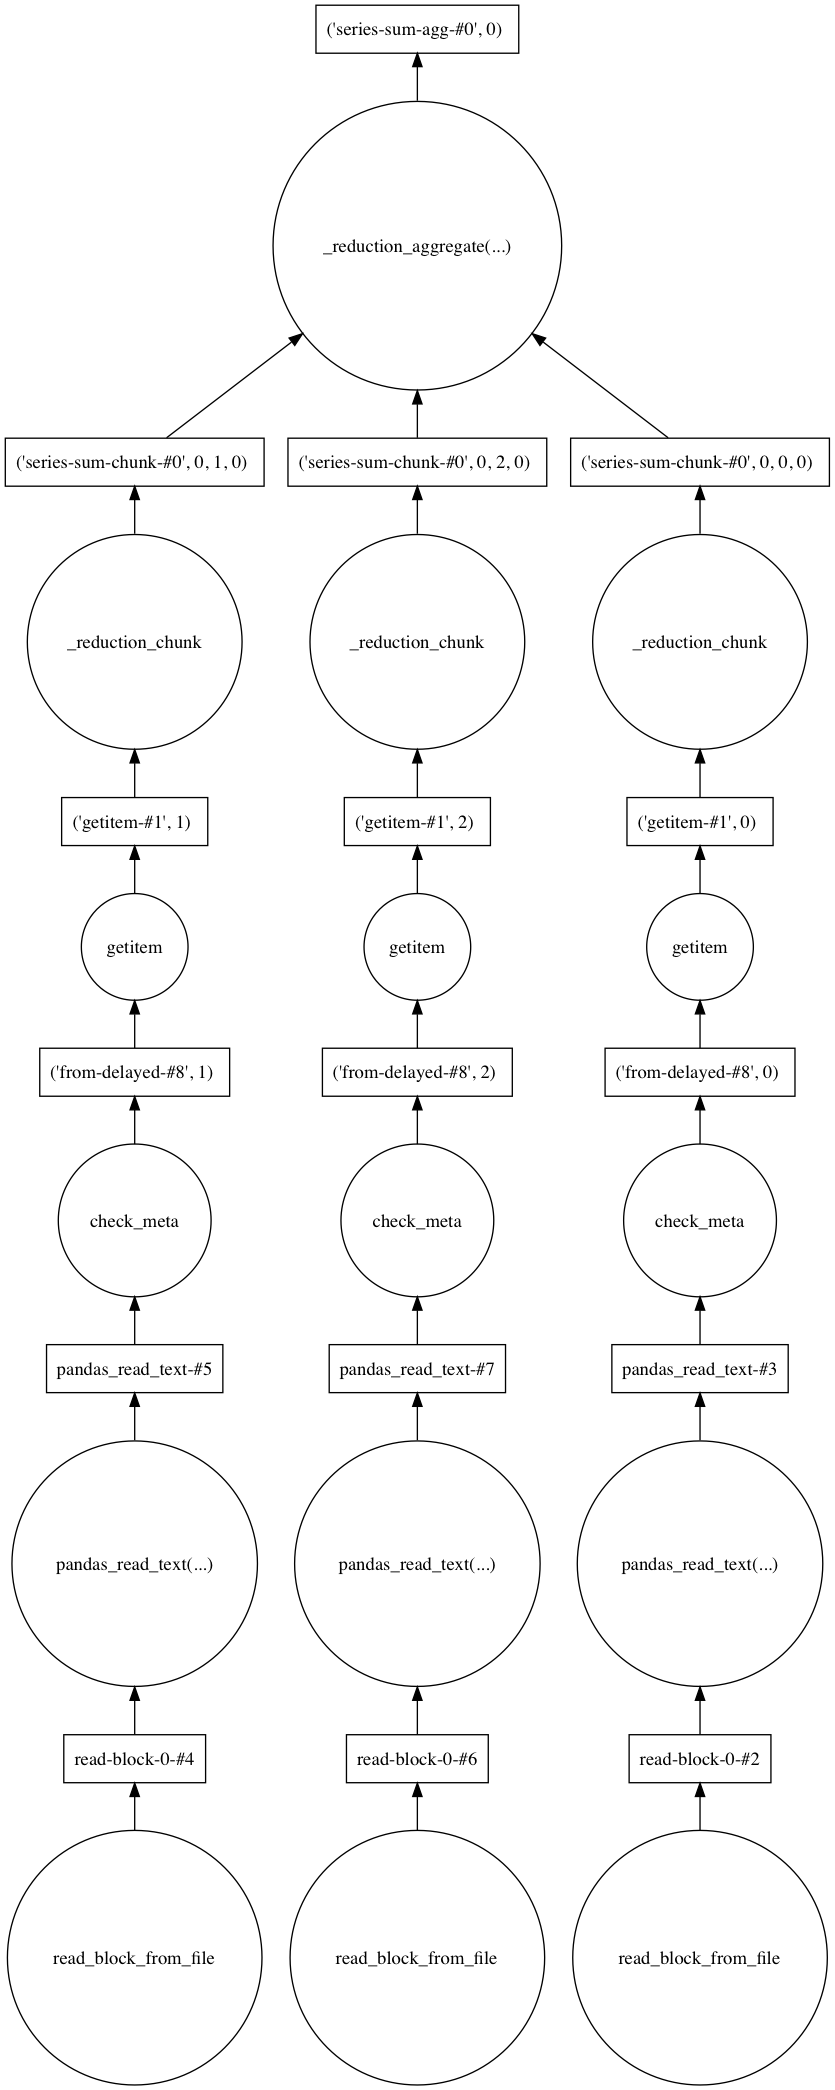

In [57]:
df.amount.sum().visualize()

Pandas is more mature and fully featured than dask.dataframe. If your data fits in memory then you should use Pandas. The dask.dataframe module gives you a limited pandas experience when you operate on datasets that don't fit comfortably in memory.

In [58]:
result = df.amount.mean()  # create lazily evaluated result
result

dd.Scalar<series-..., dtype=float64>

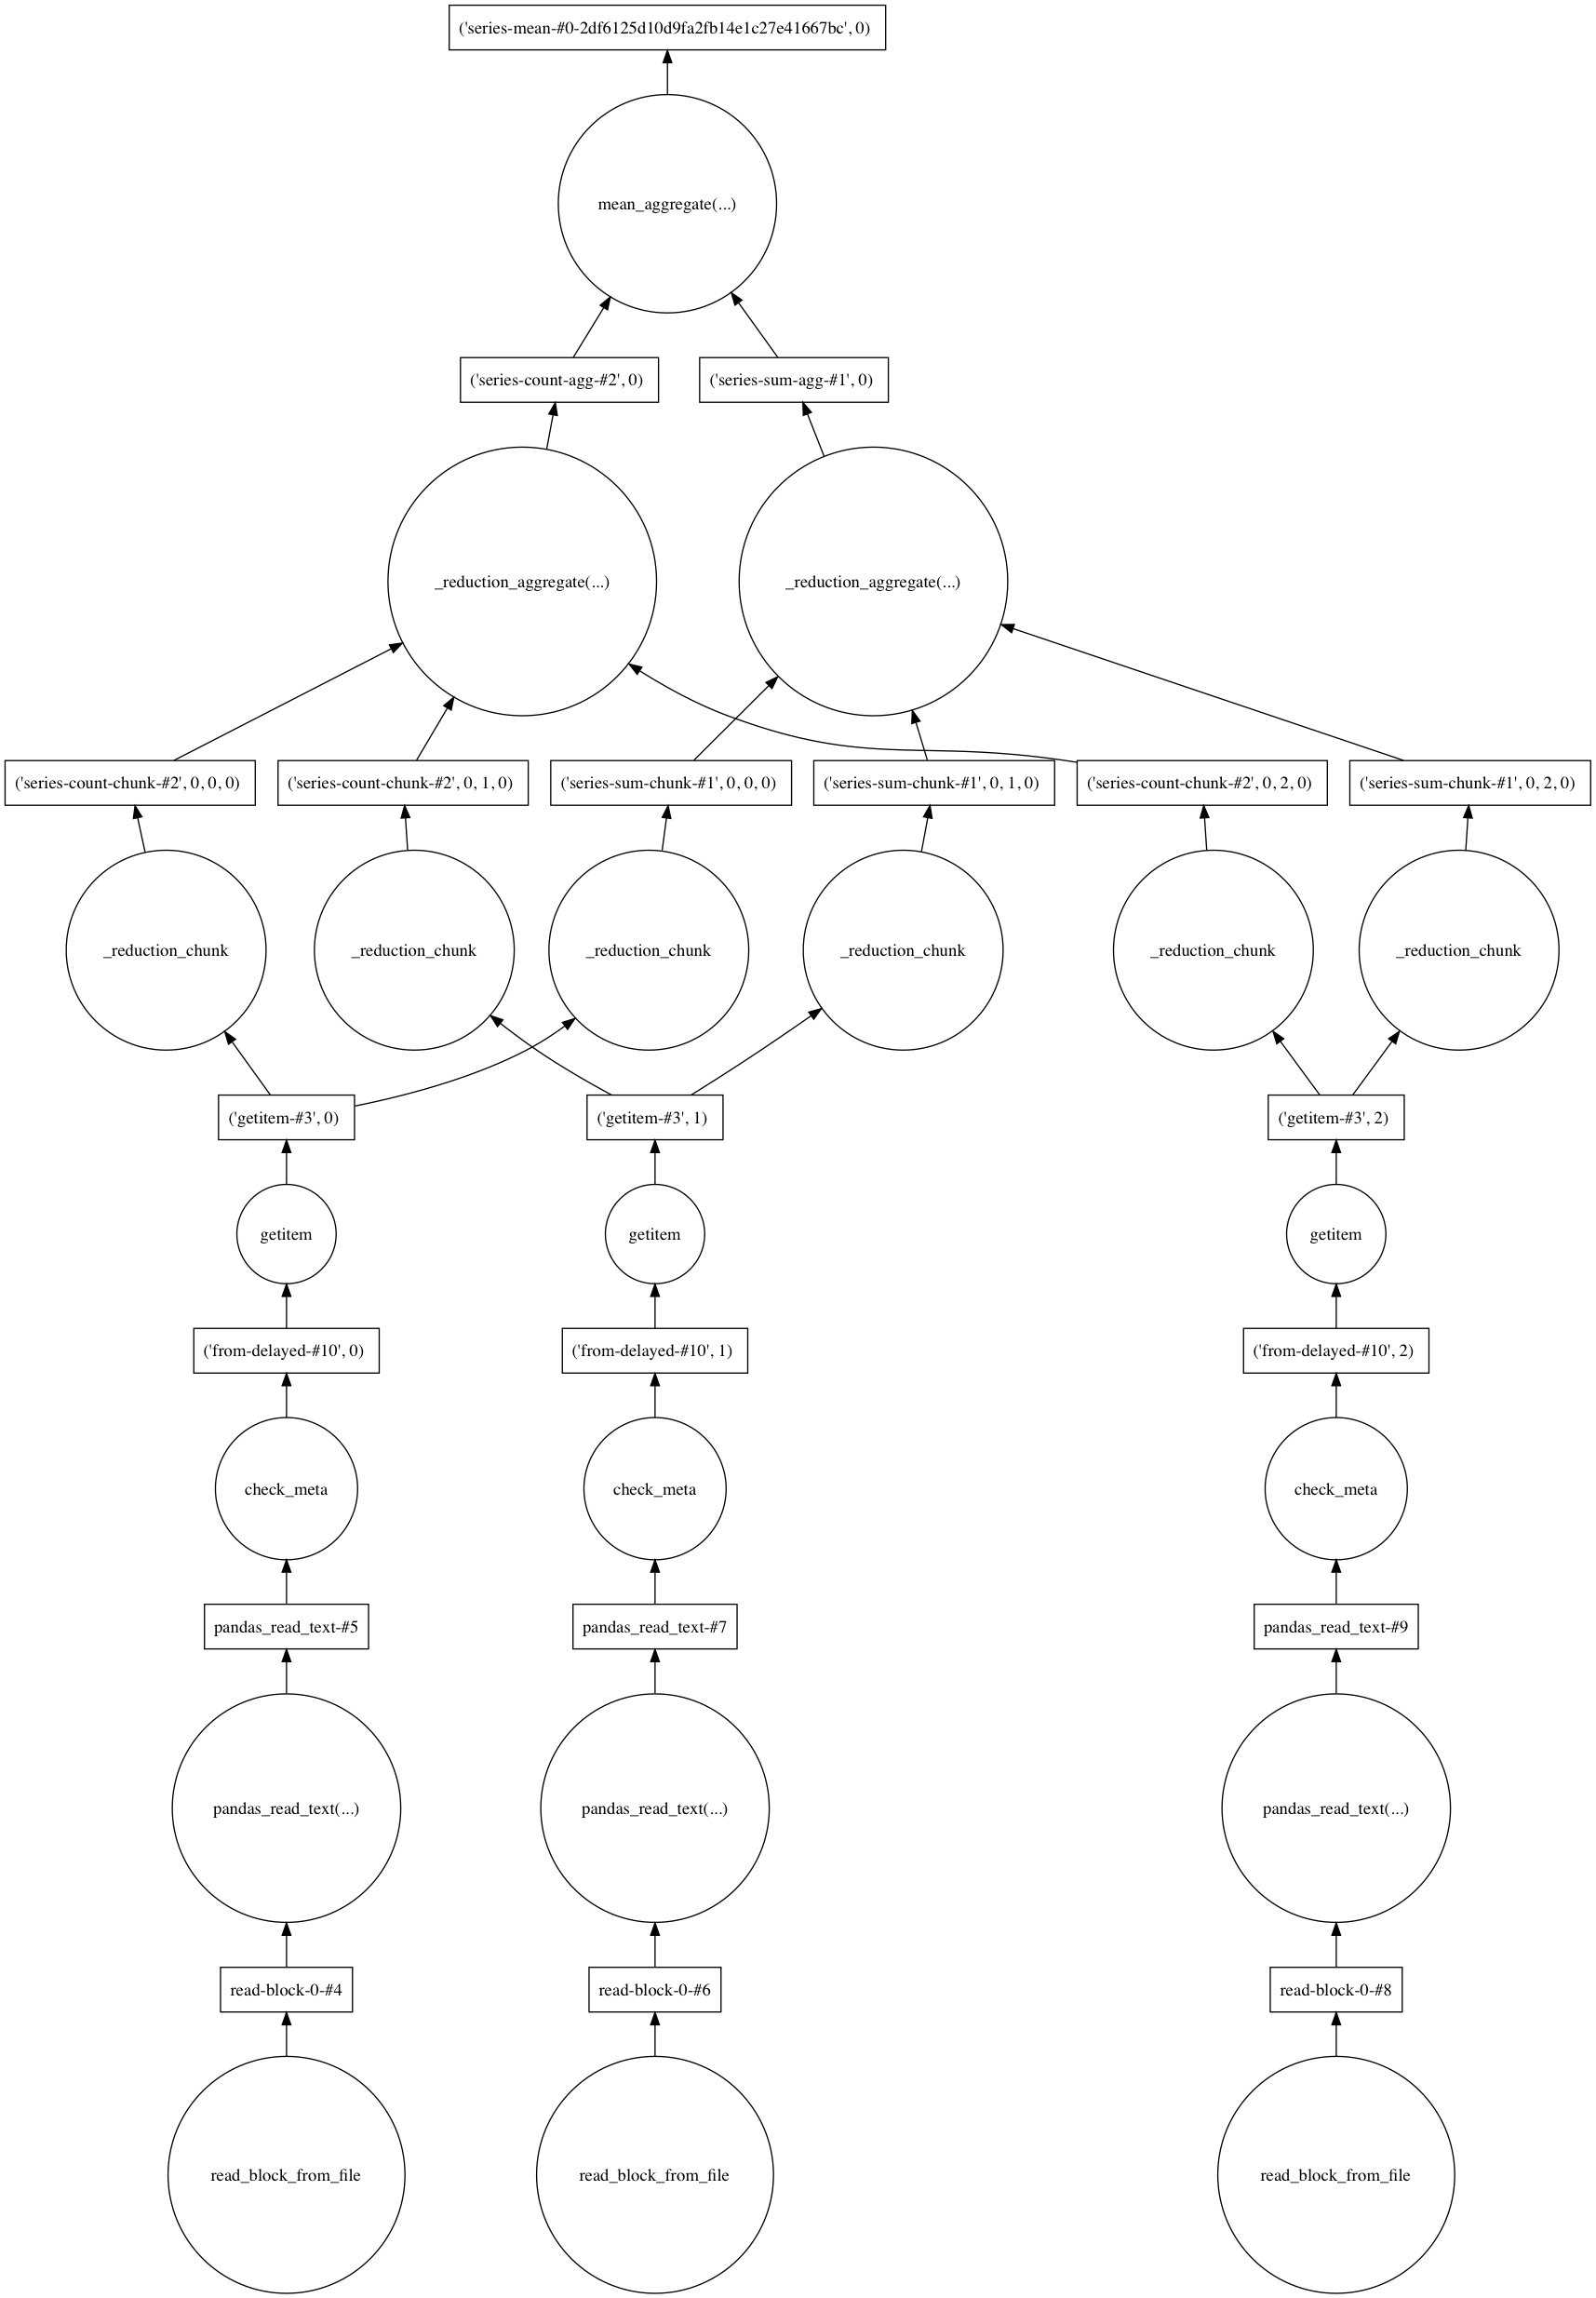

In [59]:
result.visualize()

In [141]:
result.compute()

1137.2445726666667

In [60]:
df.head()

,id,names,amount
0,496,Oliver,387
1,211,Ursula,856
2,3,Victor,110
3,435,Jerry,32
4,492,Edith,44


In [61]:
df.names.drop_duplicates().compute()

0        Oliver
1        Ursula
2        Victor
3         Jerry
4         Edith
5        Yvonne
6         Quinn
8           Dan
9        Xavier
10       Hannah
15      Charlie
16       Ingrid
18          Bob
19        Zelda
21        Laura
24        Kevin
26     Patricia
27        Frank
28        Alice
29       George
36          Ray
42      Norbert
48        Sarah
60        Wendy
85          Tim
107     Michael
Name: names, dtype: object

In [62]:
len(df[df.amount < 0]) # negative amounts

452286

In [63]:
len(df[df.amount > 0]) # positive amounts

2531852

In [64]:
df.groupby(df.names).amount.mean().compute()

names
Alice       2508.051390
Bob         1336.849900
Charlie      485.139383
Dan         1299.045077
Edith       1025.041012
Frank       1676.706287
George      1058.726381
Hannah       953.869492
Ingrid      1006.719434
Jerry       1645.286647
Kevin        922.201105
Laura        495.149657
Michael     1345.825831
Norbert      722.564767
Oliver      1269.053591
Patricia    1817.688880
Quinn       1074.055612
Ray         1554.269295
Sarah       1498.498784
Tim         1598.877913
Ursula       764.215961
Victor       375.142002
Wendy        693.313988
Xavier      1157.289965
Yvonne       952.630628
Zelda        490.856917
Name: amount, dtype: float64

In [65]:
df2 = df[df.amount < 0]
df2.groupby(df2.names).amount.mean().compute() # average withdrawl

names
Alice       -120.714215
Bob        -1728.714615
Charlie     -251.804069
Dan        -1313.837761
Edith      -1097.194948
Frank       -319.773684
Hannah      -269.893905
Ingrid       -13.573099
Jerry       -103.716071
Kevin       -363.054098
Laura       -227.188984
Michael     -234.644567
Norbert     -475.929186
Oliver      -739.302774
Patricia   -1135.997111
Quinn        -28.635026
Ray         -273.699572
Sarah       -679.055535
Tim         -193.337299
Ursula      -299.486108
Victor      -367.541529
Wendy       -278.416632
Xavier      -222.303709
Yvonne      -410.876500
Zelda       -506.763380
Name: amount, dtype: float64

In `dask.dataframe` this index becomes even more important. Recall that one Dask DataFrame consists of several Pandas DataFrames. These dataframes are separated along the index by value. For example, when working with time series we may partition our large dataset by month.

Recall that these many partitions of our data may not all live in memory at the same time, instead they might live on disk; we simply have tasks that can materialize these pandas DataFrames on demand.

Partitioning your data can greatly improve efficiency. Operations like loc, groupby, and merge/join along the index are much more efficient than operations along other columns. You can see how your dataset is partitioned with the .divisions attribute. Note that data that comes out of simple data sources like CSV files aren't intelligently indexed by default. In these cases the values for `.divisions` will be None.

In [66]:
df = dd.read_csv(filename)
df.divisions

(None, None, None, None)

In [67]:
df2 = df.set_index('names')
df2.divisions

('Alice', 'Hannah', 'Laura', 'Zelda')

In [68]:
df2.npartitions

3